In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Assumptions

In [2]:
# Gas Truck Aassumptions
g_tube_unit = 574000 #$/module
g_trailer = 60000 #$/trailer
g_variable_o_m = 0.01 # for Non-Fuel
g_fixed_o_m = 0.04
crf_tube_trailer = 0.12
g_truck_capacity = 796 #kg/truck
g_pmax = 500  # 500 atm
g_pmin = 50 # atm
g_net_delivery = 661 #kg/truck key issue
g_load_unload_time = 3 #hours/ trip

In [3]:
# Liquid Truck Assumptions

l_tank_unit = 890000 #$/module
l_trailer = 60000 #$/trailer
l_variable_o_m = 0.01 # for Non-Fuel
l_fixed_o_m = 0.04
crf_tank_trailer = 0.12
l_truck_boil_off_rate = 0.30 # %/day
l_truck_capacity = 4000 # kg/truck
l_load_unload_time = 5.5 #hr/ trip

In [4]:
# General Truck Assumptions
cab_cost = 350000 #$/ cab
crf_cab = 0.26
fuel_economy = 7.11 # miles/kg of hydrogen
average_speed = 40 #km/hr
truck_availability = 24 #hr/day
hour_per_driver = 9.8 #hr/driver
driver_wage_benefits = 24.74 #$/hr
truck_cf = 0.8 # truck capacity factor
driving_circuity_factor = 0
fuel_price = 9 # $/kg

In [5]:
# Liquefaction Assumptions

l_base_plant_size = 20000 #kg/day
l_cost_base_plant = 62000000 # $
scale_factor_liquefier = 0.80
CRF_liquefier = 0.1
l_energy_use = 10 # kWh/kg
l_electricity_cost = 0.080 # $/kWh
l_o_and_m_cost = 0.05

# Compression

c_energy_use = 3.41286114500405 # kWh/d
c_overcapacity = 0.23
c_base_size = 20 #kW
c_base_cost = 245353
c_scale_factor = 0.46
c_crf = 0.13
c_o_and_m_cost = 0.04
c_electricity_cost = 0.08 # $/kWh

In [6]:
# Electricity 

electricity_cost = 0.08
ca_primary_energy = 2.5 #ratio
elec_CO2_emissions = 369 # grams/ kWh

annual_plant_cf = 1
h_fuel_ci = 4840 # kg of CO2e/kg H2

# Functions to Run the Model

In [7]:
# Function to see how many stations will be created

def number_of_stations(delivery_requirement, station_size, system_utilization):
    number_of_stations = delivery_requirement/station_size/system_utilization
    return number_of_stations

def idealized_city_radius_truck_delivery_distance(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):
    station_count = number_of_stations(delivery_requirement, station_size, system_utilization)
    icm_factor = 1.4234
    truck_distance = icm_factor * station_count # based on the number of stations
    average_delivery_distance = city_radius * truck_distance/ station_count + transmission_distance
    return average_delivery_distance

In [8]:
# Function to see the design size of the compressor

def design_compressor_truck(delivery_requirement, system_utilization):
    # Only need to change the size of the compressors because trucks are more variable and can be based on the actual demand
    
    design_capacity = 0 # to initialize the design capacity
    
    if delivery_requirement/ system_utilization < delivery_requirement:
        design_capacity = delivery_requirement
    else: 
        design_capacity = delivery_requirement/ system_utilization

    design_annual_production = design_capacity * annual_plant_cf * 365 # multiplying since there is 365 days in a year
    total_compressor_energy_use = c_energy_use * design_capacity * annual_plant_cf
    

    actual_c_energy_use = c_energy_use * delivery_requirement * annual_plant_cf
    design_compressor_size = total_compressor_energy_use/ 24 * (1+c_overcapacity)
    
    return design_compressor_size, actual_c_energy_use
    
def design_liquefier_truck(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):
    # Only need to change the size of the compressors because trucks are more variable and can be based on the actual demand
    
    design_capacity = 0 # to initialize the design capacity
    
    if delivery_requirement/ system_utilization < delivery_requirement:
        design_capacity = delivery_requirement
    else: 
        design_capacity = delivery_requirement/ system_utilization
    
    annual_production = delivery_requirement * 365 * annual_plant_cf

    average_delivery_distance = idealized_city_radius_truck_delivery_distance(delivery_requirement, station_size, 
                                                                              system_utilization, city_radius, 
                                                                              transmission_distance)
    
    driving_time_per_trip = math.floor(average_delivery_distance * 2/ average_speed*10)/10
    
    delivered_product = annual_production * math.e**(-(driving_time_per_trip/2)*l_truck_boil_off_rate/100) # Might need to change depending on if we include the leakage rate or not
        
    liquefier_plant_size = design_capacity * annual_plant_cf
    actual_l_energy_use = l_energy_use * delivered_product * annual_plant_cf
    return liquefier_plant_size, actual_l_energy_use, delivered_product

## Gas Trucks Costs Calculations

In [9]:
def gas_truck_capital_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):
    average_delivery_distance = idealized_city_radius_truck_delivery_distance(delivery_requirement, station_size, 
                                                                              system_utilization, city_radius, 
                                                                              transmission_distance)
    annual_production = delivery_requirement * 365 * annual_plant_cf
    
    driving_time_per_trip = math.floor(average_delivery_distance * 2/ average_speed*10)/10
    gas_t_availability = truck_availability * truck_cf * 365

    trips_per_year = annual_production/ g_net_delivery
    time_for_each_trip = average_delivery_distance * 2 / average_speed
    
    total_driving_time = trips_per_year * time_for_each_trip
    total_loading_unloading_time = trips_per_year * g_load_unload_time
    total_delivery_time = total_driving_time + total_loading_unloading_time

    truck_requirement = math.ceil(total_delivery_time/ gas_t_availability)

# Need double the amount of tube trailers to fulfill the delivery 
    
    
    tube_trailer_requirement = 2 * truck_requirement
    tubes_undercarriage_requirement_costs = tube_trailer_requirement * (g_tube_unit + g_trailer)
    truck_requirement_costs = truck_requirement * cab_cost 
    total_truck_trailer_capital_cost =  tubes_undercarriage_requirement_costs + truck_requirement_costs

    # Now have to calculate the compressor capital costs

    design_compressor_size, actual_c_energy_use  = design_compressor_truck(delivery_requirement, system_utilization)

    compressor_capital_costs = c_base_cost * (design_compressor_size/ c_base_size)**c_scale_factor
    total_capital_costs = (total_truck_trailer_capital_cost + compressor_capital_costs)
    
    return total_truck_trailer_capital_cost, compressor_capital_costs, total_capital_costs , tubes_undercarriage_requirement_costs, truck_requirement_costs, total_truck_trailer_capital_cost

In [10]:
gas_truck_capital_costs(100000, 2000, 0.8, 32, 100)

(131058000,
 6131827.451559894,
 137189827.4515599,
 102708000,
 28350000,
 131058000)

In [11]:
def gas_truck_operating_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):
    
    average_delivery_distance = idealized_city_radius_truck_delivery_distance(delivery_requirement, station_size, 
                                                                              system_utilization, city_radius, 
                                                                              transmission_distance)
    annual_production = delivery_requirement * 365 * annual_plant_cf
    driver_time = truck_cf * 365 * hour_per_driver # hours/ year

    trips_per_year = annual_production/ g_net_delivery
    time_for_each_trip = average_delivery_distance * 2 / average_speed
    
    total_driving_time = trips_per_year * time_for_each_trip
    total_loading_unloading_time = trips_per_year * g_load_unload_time
    total_delivery_time = total_driving_time + total_loading_unloading_time
    
    drivers_required = math.ceil(total_delivery_time/ driver_time)
    
    labor_costs = driver_wage_benefits  * driver_time * drivers_required
    total_distance = trips_per_year * average_delivery_distance * 2 # to account for going there and back
    fuel_usage = math.floor(total_distance/1.60934/fuel_economy*1000)/1000
    fuel_costs = fuel_usage * fuel_price

    design_compressor_size, actual_c_energy_use = design_compressor_truck(delivery_requirement, system_utilization)
    compressor_electricity_costs = actual_c_energy_use*c_electricity_cost*365

    total_truck_trailer_capital_cost, compressor_capital_costs, total_capital_costs, tubes_undercarriage_requirement_costs, truck_requirement_costs, total_truck_trailer_capital_costs = gas_truck_capital_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance)
    variable_non_fuel_o_m = g_variable_o_m * total_truck_trailer_capital_cost # %/yr of capital

    total_variable_operating_costs = labor_costs + fuel_costs + compressor_electricity_costs + variable_non_fuel_o_m


    
    truck_fixed_o_m = total_truck_trailer_capital_cost * g_fixed_o_m
    compressor_o_m_costs = c_o_and_m_cost * compressor_capital_costs
    truck_annual_capital = tubes_undercarriage_requirement_costs * crf_tube_trailer + truck_requirement_costs * crf_cab
    compressor_annual_capital = compressor_capital_costs * c_crf
    total_capital_costs = truck_annual_capital + compressor_annual_capital

    total_operating_costs = total_variable_operating_costs +  truck_fixed_o_m  + compressor_o_m_costs + truck_annual_capital + compressor_annual_capital
    total_actual_operating = (total_variable_operating_costs +  truck_fixed_o_m  + compressor_o_m_costs)/ (delivery_requirement * annual_plant_cf * 365)
    
    storage_costs = 0.072 #$/kg
    per_unit_costs = total_operating_costs/(delivery_requirement * annual_plant_cf * 365)+ storage_costs

    fuel_co2_emissions = fuel_usage * h_fuel_ci/ 1000000 * 1000000 / (delivery_requirement * annual_plant_cf * 365)
    compression_co2_emissions = c_energy_use * elec_CO2_emissions
    total_emissions_per_unit =  fuel_co2_emissions + compression_co2_emissions
    total_emissions =  (fuel_co2_emissions + compression_co2_emissions) * (delivery_requirement * annual_plant_cf * 365)
    
    return  per_unit_costs,total_emissions_per_unit, total_capital_costs/ (delivery_requirement * annual_plant_cf * 365)+storage_costs, total_actual_operating, total_emissions/ (delivery_requirement * annual_plant_cf * 365)  #total_operating_costs,

In [12]:
gas_truck_operating_costs(5000, 2000, 0.8, 32, 100)

(2.111155253518331,
 1445.6252850489602,
 0.848294136486856,
 1.2628611170314747,
 1445.6252850489602)

## Liquid Trucks Costs Calculations
    

In [13]:
def liquid_truck_capital_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):
    average_delivery_distance = idealized_city_radius_truck_delivery_distance(delivery_requirement, station_size, 
                                                                              system_utilization, city_radius, 
                                                                              transmission_distance)
    annual_production = delivery_requirement * 365 * annual_plant_cf
    
    driving_time_per_trip = math.floor(average_delivery_distance * 2/ average_speed*10)/10
    liquid_t_availability = truck_availability * truck_cf * 365

    trips_per_year = annual_production/ l_truck_capacity
    time_for_each_trip = average_delivery_distance * 2 / average_speed
    
    total_driving_time = trips_per_year * time_for_each_trip
    total_loading_unloading_time = trips_per_year * l_load_unload_time
    total_delivery_time = total_driving_time + total_loading_unloading_time

    truck_requirement = math.ceil(total_delivery_time/ liquid_t_availability)
    
    tank_undercarriage_costs = 1 * truck_requirement * (l_tank_unit + l_trailer) # Change the 1 if you need more than one truck
    truck_requirement_costs = truck_requirement * cab_cost 
    total_truck_trailer_capital_cost =  tank_undercarriage_costs + truck_requirement_costs

    # Now have to calculate the liquefier capital costs

    liquefier_plant_size, actual_l_energy_use, delivered_product = design_liquefier_truck(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance)

    if liquefier_plant_size < l_base_plant_size:
        liquefier_capital_costs = l_cost_base_plant * (liquefier_plant_size/ l_base_plant_size)
    else: 
        liquefier_capital_costs = l_cost_base_plant * (liquefier_plant_size/ l_base_plant_size)**scale_factor_liquefier
    
    total_capital_costs = total_truck_trailer_capital_cost + liquefier_capital_costs
    
    return total_truck_trailer_capital_cost, liquefier_capital_costs, total_capital_costs, tank_undercarriage_costs, truck_requirement_costs, total_truck_trailer_capital_cost

In [14]:
liquid_truck_capital_costs(100000, 2000, 0.8, 32, 100)

(22100000, 268593626.72261924, 290693626.72261924, 16150000, 5950000, 22100000)

In [15]:
def liquid_truck_operating_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):
    
    average_delivery_distance = idealized_city_radius_truck_delivery_distance(delivery_requirement, station_size, 
                                                                              system_utilization, city_radius, 
                                                                              transmission_distance)
    annual_production = delivery_requirement * 365 * annual_plant_cf
    driver_time = truck_cf * 365 * hour_per_driver # hours/ year

    trips_per_year = annual_production/ l_truck_capacity
    time_for_each_trip = average_delivery_distance * 2 / average_speed
    
    total_driving_time = trips_per_year * time_for_each_trip
    total_loading_unloading_time = trips_per_year * l_load_unload_time
    total_delivery_time = total_driving_time + total_loading_unloading_time
    
    drivers_required = math.ceil(total_delivery_time/ driver_time)
    
    labor_costs = driver_wage_benefits  * driver_time * drivers_required
    total_distance = trips_per_year * average_delivery_distance * 2 # to account for going there and back
    fuel_usage = math.floor(total_distance/1.60934/fuel_economy*1000)/1000
    fuel_costs = fuel_usage * fuel_price

    design_liquefier_size, actual_l_energy_use, delivered_product = design_liquefier_truck(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance)
    liquefier_electricity_costs = actual_l_energy_use * l_electricity_cost

    total_truck_trailer_capital_cost, liquefier_capital_costs, total_capital_costs, tank_undercarriage_costs, truck_requirement_costs, total_truck_trailer_capital_cost = liquid_truck_capital_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance)
    variable_non_fuel_o_m = l_variable_o_m * total_truck_trailer_capital_cost # %/yr of capital

    total_variable_operating_costs = labor_costs + fuel_costs + liquefier_electricity_costs + variable_non_fuel_o_m


    
    truck_fixed_o_m = total_truck_trailer_capital_cost * l_fixed_o_m
    liquefier_o_m_costs = l_o_and_m_cost * liquefier_capital_costs
    truck_annual_capital = tank_undercarriage_costs * crf_tank_trailer + truck_requirement_costs * crf_cab
    liquefier_annual_capital = liquefier_capital_costs * CRF_liquefier

    total_capital_costs = truck_annual_capital+liquefier_annual_capital

    total_operating_costs = total_variable_operating_costs +  truck_fixed_o_m  + liquefier_o_m_costs + truck_annual_capital + liquefier_annual_capital
    total_actual_operating = (total_variable_operating_costs +  truck_fixed_o_m  + liquefier_o_m_costs)/ (delivered_product * annual_plant_cf)
    
    storage_costs = 0.02 #$/kg
    per_unit_costs = total_operating_costs/(delivered_product * annual_plant_cf)+ storage_costs 

    fuel_co2_emissions = fuel_usage * h_fuel_ci/ 1000000 * 1000000 / (delivered_product * annual_plant_cf * 365)
    liquefaction_co2_emissions = l_energy_use * elec_CO2_emissions
    total_emissions_per_unit =  fuel_co2_emissions + liquefaction_co2_emissions
    total_emissions = total_emissions_per_unit * (delivered_product * annual_plant_cf * 365)
    
    return per_unit_costs,total_emissions_per_unit, total_capital_costs/ (delivered_product * annual_plant_cf)+storage_costs, total_actual_operating, total_emissions/ (delivered_product * annual_plant_cf * 365) #total_operating_costs, 

In [16]:
liquid_truck_operating_costs(100000, 3000, 0.8, 32, 100)

(2.201163957729383,
 3690.0852519071823,
 0.8603796674096321,
 1.3407842903197509,
 3690.0852519071823)

## Pipe Calculations

In [17]:
# Transmission Pipe

def pipe_transmission_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):

    if delivery_requirement/system_utilization < delivery_requirement:
        mdot_design = delivery_requirement # if I wanted to incorporate leakages
    else:
        mdot_design = delivery_requirement/system_utilization

    transmission_in_meters = transmission_distance * 1000
    dynamic_viscosity = 0.000006 # N-s/m^3
    q_design = mdot_design/ 0.09/ (60*60*24)
    
    temp = 298 # Kelvin
    z = 1
    pipeline_out =  6894757 # Pa (P_out)
    yield_strength = 250 # MPa
    pipe_safety_factor = 0.56
    p_steel = 7801 # kg/m^3
    mdot_normal = delivery_requirement # will be different than the distribution
    # can incorporate leakages into this 
    steel_price = 6.95 #$/kg
    pipe_size_factor = 5 # x mater
    pipe_install = 730000 # $/km
    crf_pipe = 0.15
    crf_compressor = 0.15
    n = 496.031246 #mol/kg
    rgas = 8.314 # J/mol K
    gamma = 1.4
    h2_MW = 0.002016 # kg
    p_atm = 101325 # Pa 
    
    c_1 = ((math.pi**2)* rgas/h2_MW)**0.5* z * temp/ p_atm

    production_p_in = 2000000 # Pa from the assumptions sheet B23
    compressor_efficiency = 1 # could be for MC
    base_compression =  n * 8.314 * 298 * (gamma/(gamma-1))*((pipeline_out/ production_p_in ) ** ((gamma - 1)/ gamma) -1)/1000/compressor_efficiency# kJ/kg

    base_unit_cost = 554 # 4/kW
    base_comp_size = 2000 # #kW
    compressor_factor = 1.1
    comp_exp = 0.8335
    operating_factor = 365
    o_and_m_per_of_cc = 0.05
    H2_LHV = 120000000

    # initializing the storage of the results 
    delivery_cost = []
    energy_loss_perc = []
    co2_emissions = []
    total_capital_costs = []
    total_operating_costs = []
    
    for inner_diameter in np.arange(0.017,0.23,0.001): # in meters
        pipe_area = (inner_diameter**2) / 4 * math.pi # m^2
        Re = inner_diameter * ((mdot_design/(60*60*24)) / pipe_area) / dynamic_viscosity # reynold's number
        colebrook_equation = 5.18 * Re ** 0.0909 # colebrook equation that relates the friction factor to the reynolds number and the relative roughness (1/f)^.5
        if (((q_design/((inner_diameter**2.5) * c_1 * colebrook_equation)) ** 2 * (temp * z * transmission_in_meters) + pipeline_out**2)**0.5) > 10000000:
            p_in = 0 # Pa
        else:
            p_in = (((q_design/((inner_diameter**2.5) * c_1 * colebrook_equation)) ** 2 * (temp * z * transmission_in_meters) + pipeline_out**2)**0.5) # Pa


        if p_in == 0:
            delta_p = 0
        else: 
            delta_p = p_in - pipeline_out


        t = p_in * inner_diameter / (2 * yield_strength * 1000000 * pipe_safety_factor - 2 * p_in)
        outer_diameter = inner_diameter + 2 * t # in meters OD in the sheet
        p_design = 2 * yield_strength * t / outer_diameter * 0.8 * 0.7 # in MPa
        w = math.pi * transmission_in_meters * p_steel * t * (inner_diameter + t )  # in kilograms

        actual_re = (inner_diameter * ((mdot_normal/ (60 * 60 * 24))/ (pipe_area)) / dynamic_viscosity)
        actual_colebrook_equation = 5.18 * Re ** 0.0909

        if p_in == 0:
            actual_p_in = 0
        else:
            actual_p_in = (((mdot_normal/0.09/(60*60*24))/(inner_diameter**2.5 * c_1 * actual_colebrook_equation))**2*(temp*z* transmission_in_meters)+ pipeline_out**2)**0.5

        if actual_p_in == 0:
            actual_delta_p = 0
        else:
            actual_delta_p = actual_p_in - pipeline_out

        pipeline_cost = w * steel_price * pipe_size_factor # keeping these values in millions
        pipe_installed_cost = pipe_install * transmission_distance

        annual_pipeline_cost = (pipeline_cost + pipe_installed_cost) * crf_pipe

        if p_in == 0:
            total_pump_work = 0
        else: 
            total_pump_work = n * rgas * temp * (gamma/(gamma - 1)) * ((actual_p_in/ production_p_in)**((gamma-1)/gamma)-1)/1000/compressor_efficiency # in kJ/kg

        design_compressor = (total_pump_work + base_compression) * mdot_design/ (60 * 60 * 24)
        compressor_pipe_p = base_compression #kJ/kg

        if  actual_p_in == 0:
            actual_pump_flow = 0
        else:
            actual_pump_flow = n * rgas * temp * (gamma/(gamma-1)) * ((actual_p_in/ pipeline_out) **((gamma-1)/gamma)-1)/1000/compressor_efficiency

        electricity_compressor = compressor_pipe_p/ 3600
        electricity_pump = actual_pump_flow/ 3600

        cc_compressor_1 = ((base_unit_cost * base_comp_size * (design_compressor * compressor_factor/ base_comp_size) ** comp_exp) * crf_compressor)
        energy_cost_1 = electricity_pump * electricity_cost * mdot_normal * operating_factor
        energy_cost_2 = electricity_compressor * electricity_cost * mdot_normal * operating_factor

        o_and_m_cost = (pipeline_cost + pipe_installed_cost + cc_compressor_1/ crf_compressor) * o_and_m_per_of_cc 

        total_annual_cost = energy_cost_1 + energy_cost_2 + cc_compressor_1 + annual_pipeline_cost + o_and_m_cost
        fixed_cost = cc_compressor_1 + annual_pipeline_cost + o_and_m_cost
        variable_cost = energy_cost_1 + energy_cost_2

        del_cost = total_annual_cost/ (delivery_requirement*365) #divided by actual H2 delivered

        total_infrastructure_cost = pipeline_cost + pipe_installed_cost + cc_compressor_1/ crf_compressor
        compressor_cost_per_m = cc_compressor_1 /transmission_in_meters 
        o_and_m_cost_per_m = o_and_m_cost/ transmission_in_meters
        energy_cost_1_per_m = energy_cost_1/ transmission_in_meters
        energy_cost_2_per_m = energy_cost_2/ transmission_in_meters
        total_cost_per_m = total_annual_cost/ transmission_in_meters

        if t > 0:
            
            delivery_cost.append(del_cost)
            energy_loss_perc.append(total_pump_work*1000/H2_LHV*ca_primary_energy)
            co2_emissions.append((electricity_compressor+electricity_pump) * elec_CO2_emissions)
            
            total_capital_costs.append((cc_compressor_1 + annual_pipeline_cost)/ (delivery_requirement*365))
            total_operating_costs.append((variable_cost+ o_and_m_cost)/ (delivery_requirement*365))
        else: 
            delivery_cost.append(np.nan)            
            energy_loss_perc.append(np.nan)
            co2_emissions.append(np.nan)
            total_capital_costs.append(np.nan)
            total_operating_costs.append(np.nan)

    delivery_cost = np.array(delivery_cost, dtype=float)
    total_capital_costs = np.array(total_capital_costs, dtype=float)
    total_operating_costs = np.array(total_operating_costs, dtype=float)
    energy_loss_perc = np.array(energy_loss_perc, dtype=float)
    co2_emissions = np.array(co2_emissions, dtype=float)
    
    # Find the index of the optimized (min) cost
    index = np.nanargmin(delivery_cost)
    storage_costs = 0.072 #$/kg of hydrogen
    optimized_delivery_cost = np.nanmin(delivery_cost)
    delivery_cost_with_storage = optimized_delivery_cost + storage_costs
    o_total_capital_costs = total_capital_costs[index] + storage_costs
    o_total_operating_costs = total_operating_costs[index] 
    optimized_energy_loss_perc = energy_loss_perc[index]
    optimized_co2_emissions = co2_emissions[index]
    total_emissions = co2_emissions[index] * (delivery_requirement*365)

    

    return delivery_cost_with_storage, optimized_co2_emissions, o_total_capital_costs, o_total_operating_costs, total_emissions / (delivery_requirement*365)  #delivery_cost_with_storage, optimized_co2_emissions,optimized_energy_loss_perc,


In [18]:

yeet = pipe_transmission_costs(926624.8, 3000, 0.8, 32, 100)
yeet

(0.2164436006339709,
 218.01645178083493,
 0.14488287091761884,
 0.07156072971635206,
 218.0164517808349)

In [19]:
# Transmission Pipe

def pipe_distribution_costs(delivery_requirement, station_size, system_utilization, city_radius, transmission_distance):
    station_count = number_of_stations(delivery_requirement, station_size, system_utilization)
    

    if delivery_requirement/system_utilization < delivery_requirement:
        mdot_design = delivery_requirement*2/(station_count)**0.5 # if I wanted to incorporate leakages
    else:
        mdot_design = delivery_requirement/system_utilization*2/(station_count)**0.5
        
    icr_pipelines_in_meters = city_radius * 2.4 * station_count ** 0.4909 * 1000
    
    dynamic_viscosity = 0.000006 # N-s/m^3
    q_design = mdot_design/ 0.09/ (60*60*24)
    
    temp = 298 # Kelvin
    z = 1
    pipeline_out =  2601000 # Pa (P_out)
    yield_strength = 250 # MPa
    pipe_safety_factor = 0.56
    p_steel = 7801 # kg/m^3
    mdot_normal = delivery_requirement # will be different than the distribution
    # can incorporate leakages into this 
    steel_price = 6.95 #$/kg
    pipe_size_factor = 5 # x mater
    pipe_install = 730000 # $/km
    crf_pipe = 0.15
    crf_compressor = 0.15
    n = 496.031246 #mol/kg
    rgas = 8.314 # J/mol K
    gamma = 1.4
    h2_MW = 0.002016 # kg
    p_atm = 101325 # Pa 
    
    c_1 = ((math.pi**2)* rgas/h2_MW)**0.5* z * temp/ p_atm

    production_p_in = 2600000 # Pa from the assumptions sheet B23
    compressor_efficiency = 1 # could be for MC
    base_compression =  n * 8.314 * 298 * (gamma/(gamma-1))*((pipeline_out/ production_p_in ) ** ((gamma - 1)/ gamma) -1)/1000/compressor_efficiency# kJ/kg

    base_unit_cost = 554 # 4/kW
    base_comp_size = 2000 # #kW
    compressor_factor = 1.1
    comp_exp = 0.8335
    operating_factor = 365
    o_and_m_per_of_cc = 0.05
    H2_LHV = 120000000

    # initializing the storage of the results 
    delivery_cost = []
    energy_loss_perc = []
    co2_emissions = []
    total_capital_costs = []
    total_operating_costs = []
    
    for inner_diameter in np.arange(0.017,0.3,0.001): # in meters
        pipe_area = (inner_diameter**2) / 4 * math.pi # m^2
        Re = inner_diameter * ((mdot_design/(60*60*24)) / pipe_area) / dynamic_viscosity # reynold's number
        colebrook_equation = 5.18 * Re ** 0.0909 # colebrook equation that relates the friction factor to the reynolds number and the relative roughness (1/f)^.5
        if (((q_design/((inner_diameter**2.5) * c_1 * colebrook_equation)) ** 2 * (temp * z * icr_pipelines_in_meters) + pipeline_out**2)**0.5) > 10000000:
            p_in = 0 # Pa
        else:
            p_in = (((q_design/((inner_diameter**2.5) * c_1 * colebrook_equation)) ** 2 * (temp * z * icr_pipelines_in_meters) + pipeline_out**2)**0.5) # Pa


        if p_in == 0:
            delta_p = 0
        else: 
            delta_p = p_in - pipeline_out


        t = p_in * inner_diameter / (2 * yield_strength * 1000000 * pipe_safety_factor - 2 * p_in)
        outer_diameter = inner_diameter + 2 * t # in meters OD in the sheet
        p_design = 2 * yield_strength * t / outer_diameter * 0.8 * 0.7 # in MPa
        w = math.pi * icr_pipelines_in_meters * p_steel * t * (inner_diameter + t )  # in kilograms

        actual_re = (inner_diameter * ((mdot_normal/ (60 * 60 * 24))/ (pipe_area)) / dynamic_viscosity)
        actual_colebrook_equation = 5.18 * Re ** 0.0909

        if p_in == 0:
            actual_p_in = 0
        else:
            actual_p_in = (((mdot_normal/0.09/(60*60*24))/(inner_diameter**2.5 * c_1 * actual_colebrook_equation))**2*(temp*z* icr_pipelines_in_meters)+ pipeline_out**2)**0.5

        if actual_p_in == 0:
            actual_delta_p = 0
        else:
            actual_delta_p = actual_p_in - pipeline_out

        pipeline_cost = w * steel_price * pipe_size_factor # keeping these values in millions
        pipe_installed_cost = pipe_install * icr_pipelines_in_meters/ 1000

        annual_pipeline_cost = (pipeline_cost + pipe_installed_cost) * crf_pipe

        if p_in == 0:
            total_pump_work = 0
        else: 
            total_pump_work = n * rgas * temp * (gamma/(gamma - 1)) * ((actual_p_in/ production_p_in)**((gamma-1)/gamma)-1)/1000/compressor_efficiency # in kJ/kg

        design_compressor = (total_pump_work + base_compression) * mdot_design/ (60 * 60 * 24)
        compressor_pipe_p = base_compression #kJ/kg

        if  actual_p_in == 0:
            actual_pump_flow = 0
        else:
            actual_pump_flow = n * rgas * temp * (gamma/(gamma-1)) * ((actual_p_in/ pipeline_out) **((gamma-1)/gamma)-1)/1000/compressor_efficiency

        electricity_compressor = compressor_pipe_p/ 3600
        electricity_pump = actual_pump_flow/ 3600

        cc_compressor_1 = ((base_unit_cost * base_comp_size * (design_compressor * compressor_factor/ base_comp_size) ** comp_exp) * crf_compressor)
        energy_cost_1 = electricity_pump * electricity_cost * mdot_normal * operating_factor
        energy_cost_2 = electricity_compressor * electricity_cost * mdot_normal * operating_factor

        o_and_m_cost = (pipeline_cost + pipe_installed_cost + cc_compressor_1/ crf_compressor) * o_and_m_per_of_cc

        total_annual_cost = energy_cost_1 + energy_cost_2 + cc_compressor_1 + annual_pipeline_cost + o_and_m_cost
        fixed_cost = cc_compressor_1 + annual_pipeline_cost + o_and_m_cost
        variable_cost = energy_cost_1 + energy_cost_2 

        del_cost = total_annual_cost/ (delivery_requirement*365) #divided by actual H2 delivered

        total_infrastructure_cost = cc_compressor_1 + annual_pipeline_cost #pipeline_cost + pipe_installed_cost + cc_compressor_1/ crf_compressor
        compressor_cost_per_m = cc_compressor_1 /icr_pipelines_in_meters
        o_and_m_cost_per_m = o_and_m_cost/ icr_pipelines_in_meters
        energy_cost_1_per_m = energy_cost_1/ icr_pipelines_in_meters
        energy_cost_2_per_m = energy_cost_2/ icr_pipelines_in_meters
        total_cost_per_m = total_annual_cost/ icr_pipelines_in_meters

        if t > 0:
            
            delivery_cost.append(del_cost)
            energy_loss_perc.append(total_pump_work*1000/H2_LHV*ca_primary_energy)
            co2_emissions.append((electricity_compressor+electricity_pump) * elec_CO2_emissions)
            total_capital_costs.append((cc_compressor_1 + annual_pipeline_cost)/ (delivery_requirement*365))
            total_operating_costs.append((variable_cost+ o_and_m_cost)/ (delivery_requirement*365))
            
        else: 
            delivery_cost.append(np.nan)            
            energy_loss_perc.append(np.nan)
            co2_emissions.append(np.nan)
            total_capital_costs.append(np.nan)
            total_operating_costs.append(np.nan)
            
    # Ensure `delivery_cost` is a numeric list

    delivery_cost = np.array(delivery_cost, dtype=float)
    total_capital_costs = np.array(total_capital_costs, dtype=float)
    total_operating_costs = np.array(total_operating_costs, dtype=float)
    energy_loss_perc = np.array(energy_loss_perc, dtype=float)
    co2_emissions = np.array(co2_emissions, dtype=float)

    
    # Find the index of the optimized (min) cost
    index = np.nanargmin(delivery_cost)
    optimized_delivery_cost = np.nanmin(delivery_cost)
    storage_costs = 0.072 #$/kg of hydrogen already added in transmission
    delivery_cost_with_storage = optimized_delivery_cost + storage_costs
    o_total_capital_costs = total_capital_costs[index]+storage_costs
    o_total_operating_costs = total_operating_costs[index]
    optimized_energy_loss_perc = energy_loss_perc[index]
    optimized_co2_emissions = co2_emissions[index]
    #optimized_co2_emissions = co2_emissions[index]
    total_emissions = co2_emissions[index] * (delivery_requirement*365)

    return delivery_cost_with_storage, optimized_co2_emissions, o_total_capital_costs, o_total_operating_costs, total_emissions/ (delivery_requirement*365) #delivery_cost_with_storage, optimized_co2_emissions, optimized_energy_loss_perc


In [20]:

yeet = pipe_distribution_costs(926624.8, 3000, 0.8, 32, 100)
yeet

(1.0234065258579992,
 398.6318899420139,
 0.7207367009069929,
 0.3026698249510061,
 398.6318899420139)

## Station Costs

In [21]:
# Does not include leakage rates

def station_costs(station_size, system_utilization):
    if station_size == 1000:
        gas_station_cost = ( 4241366 * 0.084859127 + 4241366 * 0.084859127 * 0.065091824 + 1.79627158733103 * station_size * 365 * system_utilization * electricity_cost)/ station_size/(365*system_utilization)# if you wanted to include leakages /(1-'Costs - Monte Carlo Analysis'!F$12)
        liquid_station_cost = (2677908.69801691* 0.084859127 +2677908.69801691* 0.084859127*0.107193306+0.541339516*station_size*365*system_utilization*electricity_cost)/ station_size/(365*system_utilization)
        pipeline_station_cost = (4241366.138*0.08485913+4241366.138*0.08485913*0.05870373+4.93707297*station_size*365*system_utilization*electricity_cost)/ station_size/(365*system_utilization)

        gas_station_emmissions = 1.79627158733103*369
        liquid_station_emmissions = 0.541339516*369
        pipeline_station_emissions = 4.93707297*369
    if station_size == 2000:
        gas_station_cost = (   6059460  * 0.084859127 + 6059460  * 0.084859127* 0.071325242 + 1.604716869 * station_size * 365 * system_utilization * electricity_cost)/ station_size/(365*system_utilization)## if you wanted to include leakages /(1-'Costs - Monte Carlo Analysis'!F$12)
        liquid_station_cost = (2542674.087* 0.084859127 +2542674.087* 0.084859127*0.121548449+0.540006412*station_size*365*system_utilization*electricity_cost)/ station_size/(365*system_utilization)
        pipeline_station_cost = (6581817.528*0.084859127+6581817.528*0.084859127*0.058132924+4.938022475*station_size*365*system_utilization*electricity_cost)/ station_size/(365*system_utilization)

        gas_station_emmissions = 1.604716869*369
        liquid_station_emmissions = 0.540006412*369
        pipeline_station_emissions = 4.938022475*369
        
    if station_size == 3000:
        gas_station_cost = (7583795   * 0.084859127+ 7583795   * 0.084859127 * 0.074076241 + 1.413162151* station_size * 365 * system_utilization * electricity_cost)/ station_size/(365*system_utilization)# if you wanted to include leakages /(1-'Costs - Monte Carlo Analysis'!F$12)
        liquid_station_cost = (3204929.723* 0.084859127 +3204929.723* 0.084859127*0.135814352+0.541054576*station_size*365*system_utilization*electricity_cost)/ station_size/(365*system_utilization)
        pipeline_station_cost = (8788842.4*0.084859127+8788842.4*0.084859127*0.063667404+4.938662159*station_size*365*system_utilization*electricity_cost)/ station_size/(365*system_utilization)

        gas_station_emmissions = 1.413162151*369
        liquid_station_emmissions = 0.541054576*369
        pipeline_station_emissions = 4.938662159*369
    return gas_station_cost, liquid_station_cost, pipeline_station_cost, gas_station_emmissions, liquid_station_emmissions, pipeline_station_emissions 

In [22]:
station_costs(1000,0.8)

(1.4565317792384285,
 0.9049651630276979,
 1.699922026555379,
 662.8242157251501,
 199.75428140399998,
 1821.77992593)

# Total Delivery Costs

# Deterministic Model

In [108]:
# pip install pyomo
#!conda install -c conda-forge pyomo -y


In [109]:
#pip install gurobipy
#!pip install cylp
#%conda install -c conda-forge coincbc pyomo -y
#import pyomo.environ as pyo
# print(pyo.SolverFactory('cbc').available())

#!conda install -c conda-forge ipopt -y
import pyomo.environ as pyo
# First, install COIN-OR solvers (which include bonmin) via conda-forge:
#!conda install -c conda-forge coincbc coinbonmin coincouenne ipopt -y


# Check availability in Pyomo
#import pyomo.environ as pyo
#print(pyo.SolverFactory('bonmin').available())
import numpy as np
import pyomo.environ as pyo


In [110]:
solver = pyo.SolverFactory("scip", executable="/usr/local/bin/scip")
if solver.available():
    print("SCIP solver is available! ✅")
else:
    print("SCIP solver is NOT available. ❌")

SCIP solver is available! ✅


In [111]:
import numpy as np
import pyomo.environ as pyo

# --- 📌 MODEL PARAMETERS (Deterministic) --- #
city_data = {
    "Atlanta": {"VMT": 159000000, "efficiency": 65, "radius": 45.9, "size": "Large"},
    "Miami": {"VMT": 151000000, "efficiency": 65, "radius": 32, "size": "Large"},
    "New Haven": {"VMT": 13000000, "efficiency": 65, "radius": 15.7, "size": "Small"},
    "Fresno": {"VMT": 13000000, "efficiency": 65, "radius": 11.5, "size": "Small"},
}

# Time periods
stages = ["2025", "2030", "2035", "2040", "2045", "2050"]

# ✅ Station capacity limit (Fixed)
station_size_map = {
    "Small": 1000,
    "Medium": 2000,
    "Large": 3000
}
station_capacity = 3000  # Max 3000 kg/day per station

# ✅ Adjusted Market penetration per city size
# (Increased to reflect realistic mode shifts)
penetration_percent = {
    "Large":   {"2025": 0.01, "2030": 0.05, "2035": 0.15, "2040": 0.30, "2045": 0.50, "2050":0.60},  
    "Medium":  {"2025": 0.01, "2030": 0.05, "2035": 0.15, "2040": 0.30, "2045": 0.50, "2050":0.60},  
    "Small":   {"2025": 0.01, "2030": 0.05, "2035": 0.15, "2040": 0.30, "2045": 0.50, "2050":0.60}   
}

# ✅ Ensure efficiency is not zero to prevent division errors
for city in city_data:
    if city_data[city]["efficiency"] == 0:
        raise ValueError(f"Efficiency for {city} is zero, causing division error!")

# ✅ Compute delivery requirement dynamically
delivery_requirement_deterministic = {
    city: {
        year: (city_data[city]["VMT"] * penetration_percent[city_data[city]["size"]][year]) 
              / city_data[city]["efficiency"]
        for year in penetration_percent[city_data[city]["size"]]
    }
    for city in city_data
}

# ✅ Convert demand data into Pyomo-friendly format
demand_data = {
    (city, year): delivery_requirement_deterministic[city][year]
    for city in delivery_requirement_deterministic
    for year in delivery_requirement_deterministic[city]
}


# ✅ Adjust Transmission Distances (longer favors pipelines)
transmission_distances_deterministic = {
    "Atlanta": 100,   # Increased distance favors pipeline
    "Miami": 100,     
    "New Haven": 100,  
    "Fresno": 100      
}

# ✅ Single deterministic utilization rate
system_utilization_avg = 0.8  # Assume 75% utilization

# ✅ Carbon cost factor ($ per ton CO2)
carbon_cost_factor = 100


# Print demand values to verify
print("🚀 Updated Hydrogen Demand (kg/day) per city and year:")
for city, demand in delivery_requirement_deterministic.items():
    print(f"{city}: {demand}")


🚀 Updated Hydrogen Demand (kg/day) per city and year:
Atlanta: {'2025': 24461.53846153846, '2030': 122307.69230769231, '2035': 366923.07692307694, '2040': 733846.1538461539, '2045': 1223076.923076923, '2050': 1467692.3076923077}
Miami: {'2025': 23230.76923076923, '2030': 116153.84615384616, '2035': 348461.53846153844, '2040': 696923.0769230769, '2045': 1161538.4615384615, '2050': 1393846.1538461538}
New Haven: {'2025': 2000.0, '2030': 10000.0, '2035': 30000.0, '2040': 60000.0, '2045': 100000.0, '2050': 120000.0}
Fresno: {'2025': 2000.0, '2030': 10000.0, '2035': 30000.0, '2040': 60000.0, '2045': 100000.0, '2050': 120000.0}


In [112]:
# --- 🏗️ PYOMO MODEL SETUP --- #
model = pyo.ConcreteModel()

# Sets
model.CITIES = pyo.Set(initialize=city_data.keys())
model.MODES = pyo.Set(initialize=["Gas_Truck", "Liquid_Truck", "Pipeline"])
model.STAGES = pyo.Set(initialize=stages)

# ✅ Define Demand as a Pyomo Parameter
model.demand = pyo.Param(
    model.CITIES, model.STAGES,
    initialize=demand_data,  # Pass the computed demand values
    within=pyo.NonNegativeReals,
    mutable=True
)

#station_capacity = 3000  # Max 3000 kg/day per station
max_truck_deliveries = 3  # Maximum number of truck deliveries per day
carbon_cost_factor = 100  # Carbon price per metric ton CO2 (adjust as needed)

# Decision Variables
model.x = pyo.Var(model.MODES, model.CITIES, model.STAGES, within=pyo.NonNegativeIntegers)  # Number of stations built
model.y = pyo.Var(model.MODES, model.CITIES, model.STAGES, within=pyo.NonNegativeReals)  # Hydrogen transported
#model.lambda_carbon = pyo.Param(initialize=carbon_cost_factor, mutable=True)  # CO2 cost multiplier

def dynamic_station_size(city, t):
    """Returns a station size based on demand levels for each year."""
    city_size = city_data[city]["size"]

    if t in ["2025", "2030"]:  # Early years
        return 1000  
    elif t in ["2035", "2040"]:  # Medium years
        return 2000  
    elif t == ["2045", "2050"]:  # Higher demand years
        return 3000  
    else:
        return station_size_map[city_size]  # Default fallback (shouldn't happen)


In [113]:
# ✅ Constraints
def demand_satisfaction(m, city, t):
    """Ensure total hydrogen demand is met using any mode."""
    return sum(m.y[mode, city, t] for mode in m.MODES) == m.demand[city, t]

model.DemandSatisfaction = pyo.Constraint(model.CITIES, model.STAGES, rule=demand_satisfaction)


def station_capacity_limit(m, mode, city, t):
    """Stations cannot transport more hydrogen than their capacity."""
    return m.y[mode, city, t] <= dynamic_station_size(city, t) * m.x[mode, city, t]

model.StationCapacityLimit = pyo.Constraint(model.MODES, model.CITIES, model.STAGES, rule=station_capacity_limit)


def truck_delivery_limit(m, city, t):
    """Dynamically scales max gas truck deliveries per station size."""
    
    station_size = dynamic_station_size(city, t)  # Returns 1000, 2000, or 3000 kg/day

    # Define dynamic max deliveries per day based on station size
    if station_size == 1000:  # Small station
        max_deliveries_per_day = 1  
    elif station_size == 2000:  # Medium station
        max_deliveries_per_day = 2  
    else:  # Large station (3000 kg/day)
        max_deliveries_per_day = 3  

    # Compute max allowable hydrogen from gas trucks per station
    max_hydrogen_per_station = max_deliveries_per_day * g_net_delivery  

    # Enforce gas truck delivery limit
    return m.y["Gas_Truck", city, t] <= (
        m.x["Gas_Truck", city, t] * max_hydrogen_per_station
    )

# ✅ Apply constraint
model.TruckDeliveryLimit = pyo.Constraint(model.CITIES, model.STAGES, rule=truck_delivery_limit)

def max_stations_constraint(m, mode, city, t):
    """Ensure that the number of stations does not exceed the minimum required to meet demand."""
    station_size = dynamic_station_size(city, t)  # Get station size dynamically
    max_stations_needed = m.demand[city, t] / station_size/ system_utilization_avg  # Compute max stations

    return m.x[mode, city, t] <= max_stations_needed  # Constrain number of stations

# ✅ Apply constraint
model.MaxStationsLimit = pyo.Constraint(model.MODES, model.CITIES, model.STAGES, rule=max_stations_constraint)

# Define a carbon emissions cap 
carbon_cap = 10000000000 # Adjust based on your assumptions


def carbon_emissions_constraint(m):
    total_emissions = 0
    for city in m.CITIES:
        for t in m.STAGES:
            station_size = dynamic_station_size(city, t)
            demand = m.demand[city, t]
            dist = transmission_distances_deterministic[city]
            radius = city_data[city]["radius"]

            for mode in m.MODES:
                if mode == "Gas_Truck":
                    emissions_per_kg = gas_truck_operating_costs(
                        pyo.value(demand), station_size, system_utilization_avg, radius, dist
                    )[1] + station_costs(station_size, system_utilization_avg)[3]
                elif mode == "Liquid_Truck":
                    emissions_per_kg = liquid_truck_operating_costs(
                        pyo.value(demand), station_size, system_utilization_avg, radius, dist
                    )[1]+ station_costs(station_size, system_utilization_avg)[4]
                else:
                    emissions_per_kg = (
                        pipe_transmission_costs(pyo.value(demand), station_size, system_utilization_avg, radius, dist)[1] +
                        pipe_distribution_costs(pyo.value(demand), station_size, system_utilization_avg, radius, dist)[1] +
                    + station_costs(station_size, system_utilization_avg)[5])

                # Accumulate total emissions (convert from kg to metric tons)
                total_emissions += emissions_per_kg * m.y[mode, city, t] 

    return total_emissions <= carbon_cap

model.CarbonEmissionsCap = pyo.Constraint(rule=carbon_emissions_constraint)


In [114]:
def total_expected_cost(m):
    """Calculates the total expected cost, including investment, operational, and emissions costs."""

    # ✅ **Investment Costs (Stations, Trucks, Pipelines)**
    investment = sum(
        station_costs(
            dynamic_station_size(city, t), 
            system_utilization_avg
        )[{"Gas_Truck": 0, "Liquid_Truck": 1, "Pipeline": 2}[mode]] 
        * m.x[mode, city, t]
        for mode in m.MODES for city in m.CITIES for t in m.STAGES
    ) + sum(
        gas_truck_operating_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[2] * m.x["Gas_Truck", city, t] +

        liquid_truck_operating_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[2] * m.x["Liquid_Truck", city, t] +

        (pipe_transmission_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[2] +
        pipe_distribution_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[2]) * m.x["Pipeline", city, t]
        
        for city in m.CITIES for t in m.STAGES
    )

    # ✅ **Operational Costs (Fuel, Maintenance, Labor)**
    expected_operational = sum(
        gas_truck_operating_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[3] * m.x["Gas_Truck", city, t] +

        liquid_truck_operating_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[3] * m.x["Liquid_Truck", city, t] +

        (pipe_transmission_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[3] +
        pipe_distribution_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[3]) * m.x["Pipeline", city, t]

        for city in m.CITIES for t in m.STAGES
    )

    # ✅ **Emissions Cost (Carbon Pricing)**
    expected_emissions = sum(gas_truck_operating_costs(
        pyo.value(m.demand[city, t]), 
        dynamic_station_size(city, t), 
        system_utilization_avg, 
        city_data[city]["radius"], 
        transmission_distances_deterministic[city])[1] * m.x["Gas_Truck", city, t] +

        liquid_truck_operating_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[1] * m.x["Liquid_Truck", city, t] +

        (pipe_transmission_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[1] +
        pipe_distribution_costs(
            pyo.value(m.demand[city, t]), 
            dynamic_station_size(city, t), 
            system_utilization_avg, 
            city_data[city]["radius"], 
            transmission_distances_deterministic[city]
        )[1]) * m.x["Pipeline", city, t]
        
        for city in m.CITIES for t in m.STAGES
    ) * carbon_cost_factor / 1e6  # Convert kg CO2 to metric tons and scale

    # ✅ **Return Total Cost**
    return investment + expected_operational + expected_emissions

# ✅ Attach the corrected Objective function
model.TotalCost = pyo.Objective(rule=total_expected_cost, sense=pyo.minimize)


In [115]:
import pyomo.environ as pyo
import pandas as pd

# ✅ Solve the model
solver = pyo.SolverFactory("scip", executable="/usr/local/bin/scip")
solver.options["display"] = 1

solver.solve(model, tee=True, load_solutions=True)

# ✅ Log and Display Results
results = []

total_hydrogen_transported = 0
total_cost_value = pyo.value(model.TotalCost)  # Overall cost from objective

# ✅ Extract per-stage results
for t in model.STAGES:
    for city in model.CITIES:
        for mode in model.MODES:
            hydrogen_transported = model.y[mode, city, t].value

            # Track total hydrogen transported
            total_hydrogen_transported += hydrogen_transported

            # Append results (per mode, city, year)
            results.append({
                "Year": t,
                "City": city,
                "Mode": mode,
                "Stations Built": round(model.x[mode, city, t].value),
                "Hydrogen Transported": hydrogen_transported
            })

# ✅ Compute overall cost per kg hydrogen
overall_cost_per_kg_hydrogen = (
    total_cost_value / total_hydrogen_transported
    if total_hydrogen_transported > 0
    else float('inf')
)

# ✅ Ensure `results` is properly formatted before DataFrame conversion
if isinstance(results, tuple):
    results = list(results)  # Convert tuple to list if necessary

# ✅ Debugging Output (Check the structure of `results`)
print("Type of results:", type(results))
if len(results) > 0:
    print("Type of first result entry:", type(results[0]))

# ✅ Create DataFrame
if isinstance(results[0], dict):  
    df = pd.DataFrame(results)  # ✅ Correct format for per-year results
else:
    # Assume `results` is a flat list of summary values and format properly
    df = pd.DataFrame([{
        "Optimized Delivery Cost ($/kg)": results[1],  
        "Optimized CO2 Emissions (kgCO2/kgH2)": results[2],
        "Optimized Capital Cost ($)": results[3],
        "Optimized Operating Cost ($)": results[4],
        "Total Emissions (kgCO2)": results[5]
    }])

# ✅ Display Detailed Table
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)


SCIP version 9.2.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 7.1.2] [GitHash: 0d2d3c7c2d]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  Readline 8.2         GNU library for command line editing (gnu.org/s/readline)
  Soplex 7.1.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b040369c]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB)
  Nauty 2.8.8          Computing Graph Automorphism Groups by Brendan D. McKay (users.cecs.an

# Stochastic Model of the Paper

In [103]:
import numpy as np
import pyomo.environ as pyo
import pandas as pd

np.random.seed(42)

# Define your external functions beforehand (as you've mentioned they exist already):
# station_costs, gas_truck_capital_costs, gas_truck_operating_costs,
# liquid_truck_capital_costs, liquid_truck_operating_costs,
# pipe_transmission_costs, pipe_distribution_costs

city_data = {
    "Atlanta": {"VMT": 159000000, "efficiency": 65, "radius": 45.9, "size": "Large"},
    "Miami": {"VMT": 151000000, "efficiency": 65, "radius": 32, "size": "Large"},
    "New Haven": {"VMT": 13000000, "efficiency": 65, "radius": 15.7, "size": "Small"},
    "Fresno": {"VMT": 13000000, "efficiency": 65, "radius": 11.5, "size": "Small"},
}

stages = ["2025", "2030", "2035", "2040", "2045", "2050"]
scenarios = ["Low", "Base", "High"]
scenario_weights = {"Low": 0.25, "Base": 0.50, "High": 0.25}
station_size_map = {"Small": 1000, "Medium": 2000, "Large": 3000}
g_net_delivery = 1000

penetration_percent = {
    "Large": {"2025":0.01,"2030":0.05,"2035":0.15,"2040":0.30,"2045":0.50,"2050":0.60},
    "Medium":{"2025":0.01,"2030":0.05,"2035":0.15,"2040":0.30,"2045":0.50,"2050":0.60},
    "Small": {"2025":0.01,"2030":0.05,"2035":0.15,"2040":0.30,"2045":0.50,"2050":0.60}
}

def triangular(low, base, high):
    return np.random.triangular(low, base, high)

def triangular_params(scenario):
    return (0.8, 0.9, 1.0) if scenario == "Low" else (0.9, 1.0, 1.1) if scenario == "Base" else (1.0, 1.1, 1.2)

def dynamic_station_size(city, year):
    if year in ["2025", "2030"]:
        return 1000
    elif year in ["2035", "2040"]:
        return 2000
    elif year in ["2045", "2050"]:
        return 3000
    return station_size_map[city_data[city]["size"]]

# Loop through each city individually
results_per_city = {}

for city_name, city_info in city_data.items():
    model = pyo.ConcreteModel()

    model.MODES = pyo.Set(initialize=["Gas_Truck", "Liquid_Truck", "Pipeline"])
    model.STAGES = pyo.Set(initialize=stages)
    model.SCENARIOS = pyo.Set(initialize=scenarios)

    demand_scenarios = {
        (year, scenario): (city_info["VMT"] * penetration_percent[city_info["size"]][year]
                           * triangular(*triangular_params(scenario))) / city_info["efficiency"]
        for year in stages for scenario in scenarios
    }
    distance_scenarios = {scenario: 100 * triangular(*triangular_params(scenario)) for scenario in scenarios}
    carbon_tax_scenarios = {scenario: 100 * triangular(*triangular_params(scenario)) for scenario in scenarios}
    def utilization_params(scenario):
        if scenario == "Low":
            return (0.30, 0.60, 0.90)
        elif scenario == "Base":
            return (0.50, 0.70, 0.90)
        else:  # High
            return (0.70, 0.80, 0.90)
    utilization_scenarios = {scenario: triangular(*utilization_params(scenario)) for scenario in scenarios}


    model.demand = pyo.Param(model.STAGES, model.SCENARIOS, initialize=demand_scenarios)
    model.distance = pyo.Param(model.SCENARIOS, initialize=distance_scenarios)
    model.carbon_tax = pyo.Param(model.SCENARIOS, initialize=carbon_tax_scenarios)
    model.utilization = pyo.Param(model.SCENARIOS, initialize=utilization_scenarios)

    model.x = pyo.Var(model.MODES, model.STAGES, within=pyo.NonNegativeIntegers)
    model.y = pyo.Var(model.MODES, model.STAGES, model.SCENARIOS, within=pyo.NonNegativeReals)

    def demand_satisfaction(m, t, scenario):
        return sum(m.y[mode, t, scenario] for mode in m.MODES) == m.demand[t, scenario]
    model.DemandSatisfaction = pyo.Constraint(model.STAGES, model.SCENARIOS, rule=demand_satisfaction)

    def station_capacity_limit(m, mode, t, scenario):
        return m.y[mode, t, scenario] <= dynamic_station_size(city_name, t) * m.x[mode, t]
    model.StationCapacityLimit = pyo.Constraint(model.MODES, model.STAGES, model.SCENARIOS, rule=station_capacity_limit)

    def truck_delivery_limit(m, t, scenario):
        max_deliveries = {1000: 1, 2000: 2, 3000: 3}[dynamic_station_size(city_name, t)]
        return m.y["Gas_Truck", t, scenario] <= m.x["Gas_Truck", t] * max_deliveries * g_net_delivery
    model.TruckDeliveryLimit = pyo.Constraint(model.STAGES, model.SCENARIOS, rule=truck_delivery_limit)

    def capacity_carry_over(m, mode, t):
        idx = stages.index(t)
        if idx == 0:
            return pyo.Constraint.Skip
        return m.x[mode, t] >= m.x[mode, stages[idx - 1]]
    max_carbon_emissions = 10000000
    def carbon_constraint(m, t):
        return sum(
            gas_truck_operating_costs(m.demand[t, s], dynamic_station_size(city_name, t), m.utilization[s], city_info["radius"], m.distance[s])[1]
            * m.x["Gas_Truck", t]
            + liquid_truck_operating_costs(m.demand[t, s], dynamic_station_size(city_name, t), m.utilization[s], city_info["radius"], m.distance[s])[1]
            * m.x["Liquid_Truck", t]
            + (pipe_transmission_costs(m.demand[t, s], dynamic_station_size(city_name, t), m.utilization[s], city_info["radius"], m.distance[s])[1]
            + pipe_distribution_costs(m.demand[t, s], dynamic_station_size(city_name, t), m.utilization[s], city_info["radius"], m.distance[s])[1])
            * m.x["Pipeline", t]
            for s in m.SCENARIOS
        ) <= max_carbon_emissions


    #✅ Non-Anticipativity Constraint (ensures the same station investment across scenarios)
    def non_anticipativity(m, mode, t, s1, s2):
        """Ensures stations built at stage t are the same across all scenarios."""
        if s1 != s2:  # Avoid redundant constraints
            return m.x[mode, t] == m.x[mode, t]
        return pyo.Constraint.Skip

    model.NonAnticipativity = pyo.Constraint(
    model.MODES, model.STAGES, model.SCENARIOS, model.SCENARIOS, rule=non_anticipativity)


    # ✅ Your custom total_expected_cost function
    def total_expected_cost(m):
        total_cost = 0
        for scenario in scenarios:
            weight = scenario_weights[scenario]
            utilization = m.utilization[scenario]
            dist = m.distance[scenario]
            carbon_cost = m.carbon_tax[scenario]
            for t in stages:
                size = dynamic_station_size(city_name, t)
                demand = m.demand[t, scenario]
                for mode, mode_idx in zip(m.MODES, [0, 1, 2]):
                    invest = station_costs(size, utilization)[mode_idx]
                    if mode == "Gas_Truck":
                        cap, oper, em = gas_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[2]+ station_costs(size, utilization)[0], \
                                        gas_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[3], \
                                        gas_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[1] + station_costs(size, utilization)[3]
                    elif mode == "Liquid_Truck":
                        cap, oper, em = liquid_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[2]+ station_costs(size, utilization)[1], \
                                        liquid_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[3], \
                                        liquid_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[1] + station_costs(size, utilization)[4]
                    else:
                        pt = pipe_transmission_costs(demand, size, utilization, city_info["radius"], dist)
                        pd = pipe_distribution_costs(demand, size, utilization, city_info["radius"], dist)
                        ps = station_costs(size, utilization)[5]
                        cap, oper, em = pt[2] + pd[2]+ station_costs(size, utilization)[2], pt[3] + pd[3], pt[1] + pd[1] + ps
                    total_cost += weight * ((invest + cap + oper) * m.x[mode, t] + em * m.x[mode, t] * carbon_cost / 1e6)
        return total_cost

    model.TotalCost = pyo.Objective(rule=total_expected_cost, sense=pyo.minimize)

    # ✅ Solve using SCIP
    solver = pyo.SolverFactory('scip', executable='/usr/local/bin/scip')
    results = solver.solve(model, tee=True)

    results_per_city[city_name] = {
        "Stations_Built": {(mode, t): round(pyo.value(model.x[mode, t])) for mode in model.MODES for t in model.STAGES},
        "Total_Cost": pyo.value(model.TotalCost)
    }

# ✅ Convert results to a DataFrame
final_results_df = pd.DataFrame([
    {"City": city, "Mode": mode, "Year": t, "Stations_Built": val}
    for city, data in results_per_city.items()
    for (mode, t), val in data["Stations_Built"].items()
])
final_results_df["Total_Cost"] = final_results_df["City"].map(lambda c: results_per_city[c]["Total_Cost"])

# ✅ Print all results
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(final_results_df)


SCIP version 9.2.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 7.1.2] [GitHash: 0d2d3c7c2d]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  Readline 8.2         GNU library for command line editing (gnu.org/s/readline)
  Soplex 7.1.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b040369c]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB)
  Nauty 2.8.8          Computing Graph Automorphism Groups by Brendan D. McKay (users.cecs.an

In [104]:
investment_cost = 0
operational_cost = 0
emissions_cost = 0

for scenario in scenarios:
    weight = scenario_weights[scenario]
    utilization = model.utilization[scenario]
    for t in stages:
        size = dynamic_station_size(city_name, t)
        dist = model.distance[scenario]
        carbon_cost = model.carbon_tax[scenario]
        demand = model.demand[t, scenario]

        for mode, mode_idx in zip(model.MODES, [0, 1, 2]):
            x_val = model.x[mode, t].value
            if mode == "Gas_Truck":
                cap, oper, em = (
                    gas_truck_capital_costs(demand, size, utilization, city_info["radius"], dist)[2],
                    gas_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[0],
                    gas_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[1]
                )
            elif mode == "Liquid_Truck":
                cap, oper, em = (
                    liquid_truck_capital_costs(demand, size, utilization, city_info["radius"], dist)[2],
                    liquid_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[0],
                    liquid_truck_operating_costs(demand, size, utilization, city_info["radius"], dist)[1]
                )
            else:
                pt = pipe_transmission_costs(demand, size, utilization, city_info["radius"], dist)
                pd = pipe_distribution_costs(demand, size, utilization, city_info["radius"], dist)
                cap, oper, em = pt[2] + pd[2], pt[0] + pd[0], pt[1] + pd[1]

            invest = station_costs(size, utilization)[mode_idx]

            investment_cost += weight * (invest + cap) * x_val
            operational_cost += weight * oper * x_val
            emissions_cost += weight * em * x_val * carbon_cost / 1e6


In [105]:
print("Investment Cost:", investment_cost)
print("Operational Cost:", operational_cost)
print("Emissions Cost:", emissions_cost)


Investment Cost: 9156615753.595285
Operational Cost: 172.23753354080978
Emissions Cost: 19.69164963074517


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


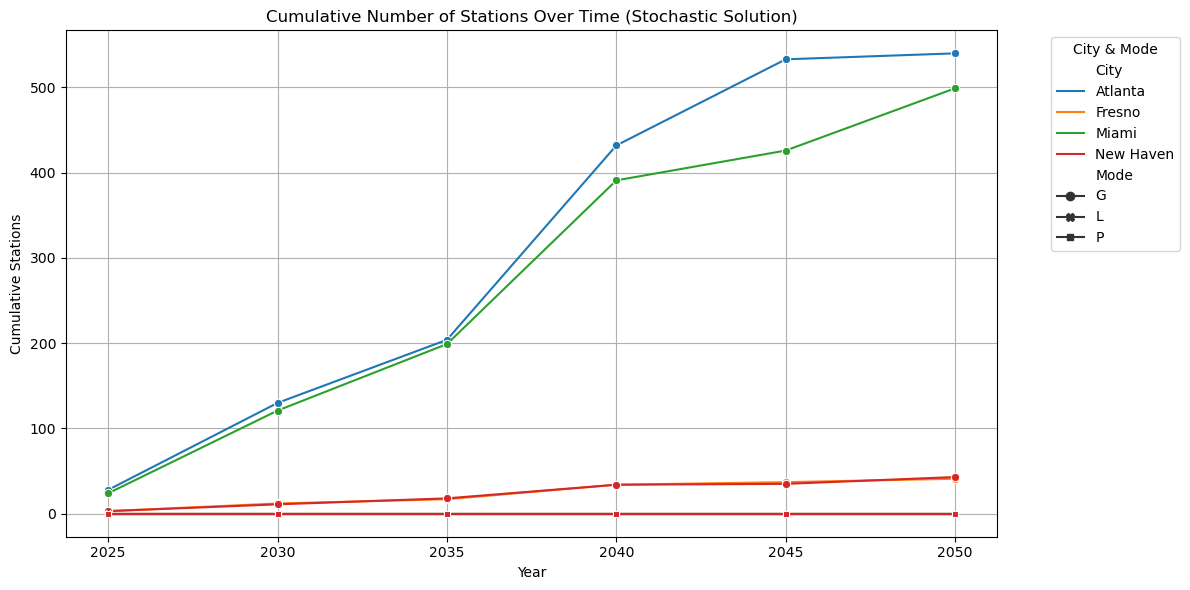

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the **stochastic** solution
years = [2025, 2030, 2035, 2040, 2045, 2050]

data = {
    ('New Haven', 'G'): [3, 11, 18, 34, 35, 43],
    ('New Haven', 'L'): [0, 0, 0, 0, 0, 0],
    ('New Haven', 'P'): [0, 0, 0, 0, 0, 0],
    
    ('Fresno', 'G'): [3, 12, 17, 34, 37, 41],
    ('Fresno', 'L'): [0, 0, 0, 0, 0, 0],
    ('Fresno', 'P'): [0, 0, 0, 0, 0, 0],
    
    ('Atlanta', 'G'): [28, 130, 204, 432, 533, 540],
    ('Atlanta', 'L'): [0, 0, 0, 0, 0, 0],
    ('Atlanta', 'P'): [0, 0, 0, 0, 0, 0],
    
    ('Miami', 'G'): [24, 121, 199, 391, 426, 499],
    ('Miami', 'L'): [0, 0, 0, 0, 0, 0],
    ('Miami', 'P'): [0, 0, 0, 0, 0, 0],
}

# Convert to DataFrame
df = pd.DataFrame(data, index=years)
df.index.name = 'Year'
df.head()

# Reshape the DataFrame
df_long = df.stack(level=[0, 1]).reset_index()
df_long.columns = ['Year', 'City', 'Mode', 'Stations']
df_long.head()

import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long, x='Year', y='Stations', hue='City', style='Mode', markers=True, dashes=False)

plt.title('Cumulative Number of Stations Over Time (Stochastic Solution)')
plt.ylabel('Cumulative Stations')
plt.grid(True)
plt.legend(title='City & Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


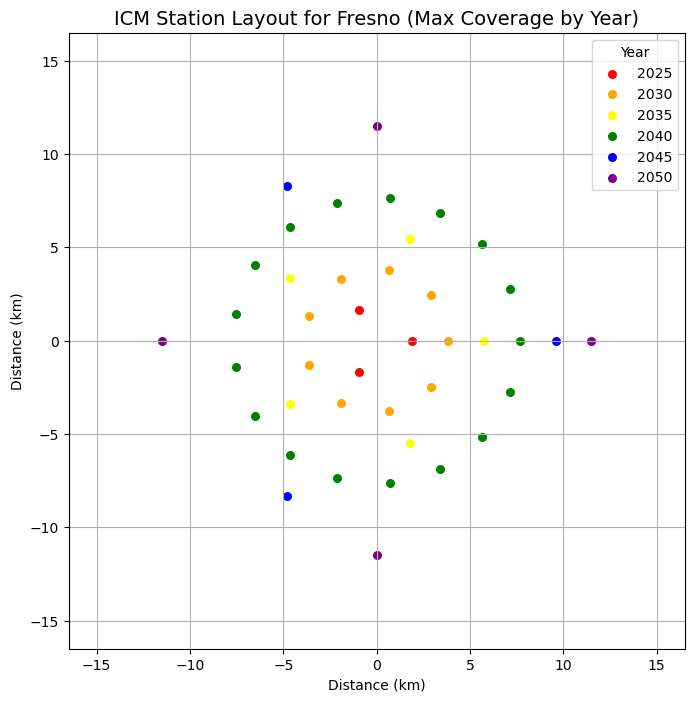

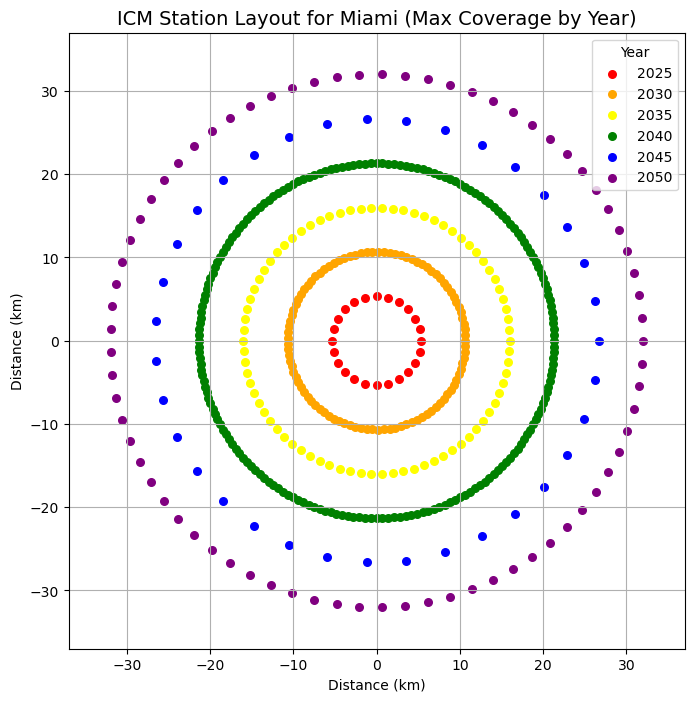

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Stochastic buildout data
station_data = {
    "Fresno": {2025: 3, 2030: 12, 2035: 17, 2040: 34, 2045: 37, 2050: 41},
    "Miami": {2025: 24, 2030: 121, 2035: 199, 2040: 391, 2045: 426, 2050: 499}
}

city_radius = {
    "Fresno": 11.5,
    "Miami": 32.0
}

year_colors = {
    2025: 'red',
    2030: 'orange',
    2035: 'yellow',
    2040: 'green',
    2045: 'blue',
    2050: 'purple'
}

def plot_icm_refined(city_name):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f'ICM Station Layout for {city_name} (Max Coverage by Year)', fontsize=14)
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')
    ax.set_aspect('equal')
    ax.set_xlim(-city_radius[city_name]-5, city_radius[city_name]+5)
    ax.set_ylim(-city_radius[city_name]-5, city_radius[city_name]+5)

    total_prev = 0
    ring_spacing = city_radius[city_name] / 6  # six time steps → six rings max

    for i, (year, total_stations) in enumerate(station_data[city_name].items()):
        new_stations = total_stations - total_prev
        total_prev = total_stations

        if new_stations <= 0:
            continue

        ring_num = i + 1
        radius = ring_num * ring_spacing
        angles = np.linspace(0, 2 * np.pi, new_stations, endpoint=False)
        x = radius * np.cos(angles)
        y = radius * np.sin(angles)

        ax.scatter(x, y, color=year_colors[year], label=str(year), s=30)

    ax.legend(title="Year", loc='upper right')
    plt.grid(True)
    plt.show()

# Plot for Fresno and Miami
plot_icm_refined("Fresno")
plot_icm_refined("Miami")
